# Pizza Delivery Analysis

We work for a large pizza delivery company with separate apps for couriers and customers. In the evening, delivery speed decreases because many couriers leave after their shifts, while order volume keeps growing. This causes a drop in delivery efficiency during shift changes.

Data scientists developed a new algorithm that helps couriers plan their last deliveries “on the way” home, so their delivery routes align with their commute.

An A/B test divides couriers into two groups: one uses the old algorithm, and the other has access to the new “on the way home” feature.

We need to analyze the experiment data and decide whether to roll out the new feature to all couriers.

### Data description:
The dataset contains the following fields:

order_id - order identifier

delivery_time - delivery time in minutes

district - delivery district

experiment_group - group assignment in the experiment (control/test)

# Importing Libraries and Dataset

In [176]:
import pandas as pd
import numpy as np
import scipy.stats as st
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(8,4)}, style="whitegrid")

In [9]:
df = pd.read_csv('pizza_data.csv')

In [11]:
df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


# Exploratory Data Analysis (EDA)

In [13]:
df.shape

(20196, 4)

In [15]:
df.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

In [23]:
df.nunique()

order_id            20196
delivery_time          72
district                3
experiment_group        2
dtype: int64

In [19]:
df.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

In [30]:
df.groupby('experiment_group').size()

experiment_group
control    10092
test       10104
dtype: int64

## EDA Summary:
* The dataset consists of 20,196 rows and 4 columns, all values in the dataset are numeric.
* There are no missing values in dataset.
* The control group has 10,092 observations, ant the test group has 10,104 observations.

# Analysis

## Q1. Average Delivery Time and Number of Orders by District

In [171]:
# df by district
time_distr = df.groupby('district', as_index=False).agg({'delivery_time': 'mean', 'order_id': 'nunique'})\
    .rename(columns={'delivery_time': 'mean_delivery_time', 'order_id': 'orders_count'})\
    .round(2)

In [160]:
time_distr

,district,mean_delivery_time,orders_count
0,Central,25.06,2396
1,Purlieus,43.43,16960
2,Suburb,62.80,840


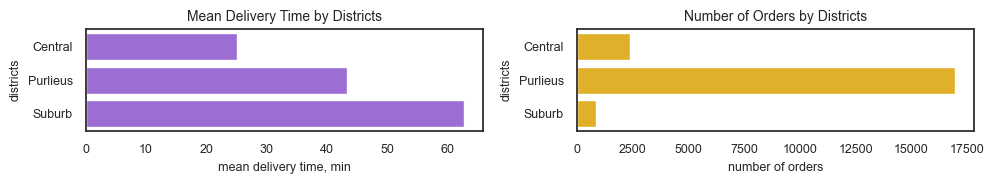

In [194]:
sns.set(rc={'figure.figsize':(10,2)}, style="white")

# mean time
plt.subplot(1,2,1)
sns.barplot(data = time_distr, x = 'mean_delivery_time', y = 'district', color='#9B5DE5')
plt.title('Mean Delivery Time by Districts', fontsize=10)
plt.xlabel('mean delivery time, min', fontsize=9)
plt.ylabel('districts', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# number of orders
plt.subplot(1,2,2)
sns.barplot(data = time_distr, x = 'orders_count', y = 'district', color='#FFBE0B')
plt.title('Number of Orders by Districts', fontsize=10)
plt.xlabel('number of orders', fontsize=9)
plt.ylabel('districts', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

## Q1 Summary:
* In the Suburb area, the average delivery time is the longest and exceeds 1 hour (63 minutes). However, the number of orders is very small - less than 1,000 orders. The long average delivery time may be due to low order density and greater distance between delivery points, which slows down deliveries.
* In the Purlieus area, the average delivery time is about 42 minutes, but the number of orders is maximum (around 17,000 orders). Despite the high number of orders, delivery times remain moderate, that may be due to good logistics and infrastructure that can handle a large order volume efficiently.
* In the Central area deliveries are the fastest (around 25 minutes) and the number of orders is medium (around 2,500 orders). Fast delivery may be due to the compactness of the area and manageable courier workload, allowing orders to be processed quickly.
* There is only a partial inverse relationship between order volume and delivery time. When planning logistics, both order density and geographic characteristics of areas should be considered.

## Q2. Hypothesis
**H₀:** The mean delivery time is the same for the test and control groups.

**H₁:** The mean delivery time differs between the test and control groups.

## Q3. Distribution of delivery time
We visualize the distribution of delivery times separately for each experimental group, broken down by delivery district.

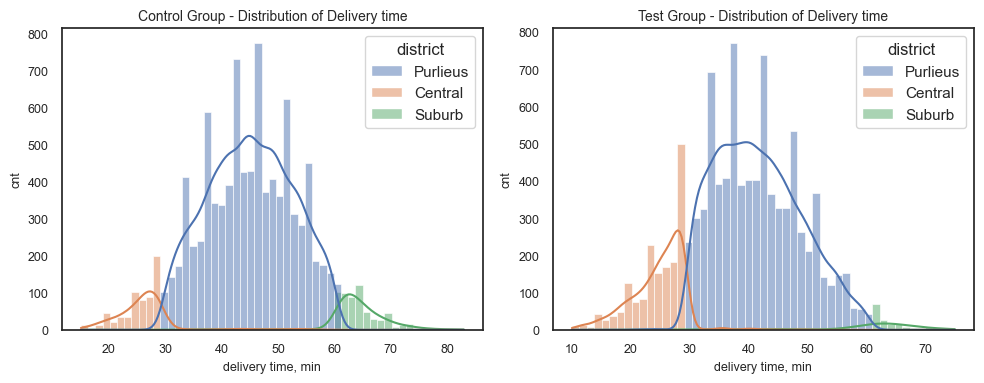

In [202]:
sns.set(rc={'figure.figsize':(10,4)}, style="white")

# control group
plt.subplot(1,2,1)
sns.histplot(data=df.query("experiment_group == 'control'"), x="delivery_time", hue="district", kde=True)
plt.title('Control Group - Distribution of Delivery time', fontsize=10)
plt.xlabel('delivery time, min', fontsize=9)
plt.ylabel('cnt', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# number of orders
plt.subplot(1,2,2)
sns.histplot(data=df.query("experiment_group == 'test'"), x="delivery_time", hue="district", kde=True)
plt.title('Test Group - Distribution of Delivery time', fontsize=10)
plt.xlabel('delivery time, min', fontsize=9)
plt.ylabel('cnt', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

## Q3 Summary:
* **Control Group:** In Purlieus most deliveries take around 40 - 50 minutes, with a peak near 45. In Central district deliveries are faster, usually 25 - 30 minutes. While in Suburb deliveries are slower, often 60 – 65 minutes.
* **Test Group:** In Purlieus distribution shifts left, most deliveries take 35 – 45 minutes, meaning they are around 5 minutes faster than in Control Group. There is a clear improvement for Central district, with the peak around 25 minutes (instead of 30 minutes before). In Suburb deliveries also seem slightly faster (around 60 minutes vs. 65 minutes).
* In all districts, the Test Group shows lower delivery times compared to the Control Group. The biggest improvements are in Purlieus and Central. Suburb shows a smaller effect, but still in the direction of improvement.

## Q4. Check for normality
We will check the assumptions of normality and calculate the standard deviation for both the test and control groups.

In [222]:
# calculate the sample standard deviation
df.groupby("experiment_group").delivery_time.std()

experiment_group
control    9.990017
test       9.883308
Name: delivery_time, dtype: float64

In [224]:
# testing the normality of delivery_time for each experiment group using D’Agostino and Pearson’s normality test
# it's more appropriate for large samples (than the Shapiro–Wilk test)
pg.normality(data=df, dv="delivery_time", group="experiment_group", method="normaltest")

,W,pval,normal
experiment_group,,,
control,0.253498,0.880955,True
test,7.024157,0.029835,False


## Q4 Summary:
* The test indicates that the values in the test group are not normally distributed, while the distribution in the control group is normal.
* Since the Test Group data are not normally distributed but the sample size is large, an independent t-test can still be used to compare group means.

## Q5. T-test
We perform an independent two-sample t-test to compare the delivery_time between the test and control groups, assuming equal variances.

In [231]:
#scipy
st.ttest_ind(a=df.query("experiment_group == 'test'").delivery_time, 
             b=df.query("experiment_group == 'control'").delivery_time, equal_var=True)

TtestResult(statistic=-43.03582663183714, pvalue=0.0, df=20194.0)

In [233]:
#pingouin
pg.ttest(x=df.query("experiment_group == 'test'").delivery_time, 
         y=df.query("experiment_group == 'control'").delivery_time)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-43.035552,20191.127788,two-sided,0.0,"[-6.29, -5.74]",0.605658,inf,1.0


## Q5 Summary:
The independent t-test revealed a significant difference in delivery times between the test and control groups, the p-value is ≤ 0.05. These results provide strong evidence to reject the null hypothesis.

# Overall Project Conclusion:
* There is only a partial inverse relationship between order volume and delivery time, highlighting the importance of both geographic and logistical factors.
* Across all areas, the Test Group shows reduced delivery times compared to the Control Group. Largest improvements are observed in Purlieus and Central, with Suburb showing modest but positive improvement.
* Distribution tests indicate the Test Group’s delivery times are non-normal, while the Control Group is normally distributed.
* An independent t-test confirms that the reduction in delivery time in the Test Group is statistically significant (p ≤ 0.05). This provides strong evidence to reject the null hypothesis of no difference.
* The intervention effectively reduces delivery times across all districts, with the greatest impact in high-density areas. 
We are rolling out the new algorithm to everyone, because the average delivery time changed significantl35%.